# 🏗️ Projet Capstone Vinci - Détection des Contours de Pièces sur Plans Architecturaux

Auteur : Fabien Lagnieu

Date : 2025-03-10

## 📖 Note Book explicatif

---
## 🎯 Objectif

Ce notebook explique la mise en œuvre du pipeline complet de traitement de fichiers GeoJSON pour :
- Générer une image binaire à partir des segments vectoriels.
- Détecter les contours des pièces, supprimer les murs, et exporter les résultats en GeoJSON.

Les plans traités sont issus de fichiers au format GeoJSON, représentant les segments des murs d’un bâtiment.  
👉 Les plans GeoJSON à analyser doivent être mis dans le dossier `00_input_geojson/`

Les plans générés sont au format GeoJSON et représentent les contours des différentes pièces détectées.  
👉 Les plans générés sont sauvegardés dans le dossier `05_rooms_contours_geojson/`

Une interface graphique permet de lancer le traitement des fichiers et d'afficher le résultat.  
👉 [Lien vers l'interface graphique](./Interface_generation.ipynb)



***Dans ce notebook, seuls cinq plans seront traités aléatoirement pour affichage des résultats.***

In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import tools.parse_geojson as pg
import capstone_contours_generation as ccg
import tools.visualization_tools as vt
import random

---
## 📁 Étape 1 : Création des dossiers de stockage

Avant de démarrer le pipeline, on initialise les répertoires de travail où seront stockés les fichiers intermédiaires :

-> Les plan geojson à analyser devont être mis dans le dossier `00_input_geojson/`

In [2]:
#Création des fichiers de stockage des données
input_dir = Path("00_input_geojson")
processed_dir = Path("01_processed_geojson")
binary_images_dir = Path("02_binary_images")
metadatas_dir = Path("03_metadatas")
contours_images_dir = Path("04_contours_images")
rooms_contours_geojson_dir = Path("05_rooms_contours_geojson")

for directory in [processed_dir, binary_images_dir, metadatas_dir, contours_images_dir, rooms_contours_geojson_dir]:
    directory.mkdir(parents=True, exist_ok=True)


---
## 🧹 Étape 2 : Nettoyage des GeoJSON et extraction des segments

On nettoie les fichiers d'entrée et on génère des segments exploitables.  
Résultat : un GeoJSON nettoyé dans `01_processed_geojson/`.

In [3]:
# Nettoyage et uniformisation des données d'entrée (geojson) en segments
files_names = []
for filepath in sorted(input_dir.iterdir()):
    files_names.append(filepath.stem)
    out_file = processed_dir / f"{filepath.stem}_clean.geojson"
    pg.clean_geojson_to_segments_and_save(filepath, out_file)

/opt/miniconda3/envs/M2datascience/lib/python3.12/site-packages/shapely/creation.py:460: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, typ, out=out, **kwargs)


#### 🔎 Visualisation des fichiers générés

Map number 0 has been loaded
   Saved parameters for inverse transformation are: [9.35511591685751, 8.81088134718489, 1]
   Has loaded 520 segments, total 1679m, mean length 3.2286m
Map number 1 has been loaded
   Saved parameters for inverse transformation are: [-35.861024766710095, -212.51037434593238, 1]
   Has loaded 958 segments, total 4451m, mean length 4.6463m
Map number 2 has been loaded
   Saved parameters for inverse transformation are: [-55.225645333170434, -224.36219701273572, 1]
   Has loaded 2706 segments, total 9181m, mean length 3.3927m
Map number 3 has been loaded
   Saved parameters for inverse transformation are: [-33.761024766710314, -202.90719700160088, 1]
   Has loaded 2728 segments, total 5319m, mean length 1.9498m
Map number 4 has been loaded
   Saved parameters for inverse transformation are: [-96597.65433833403, -82411.47514528442, 0.001]
   Has loaded 5681 segments, total 5312m, mean length 0.9350m


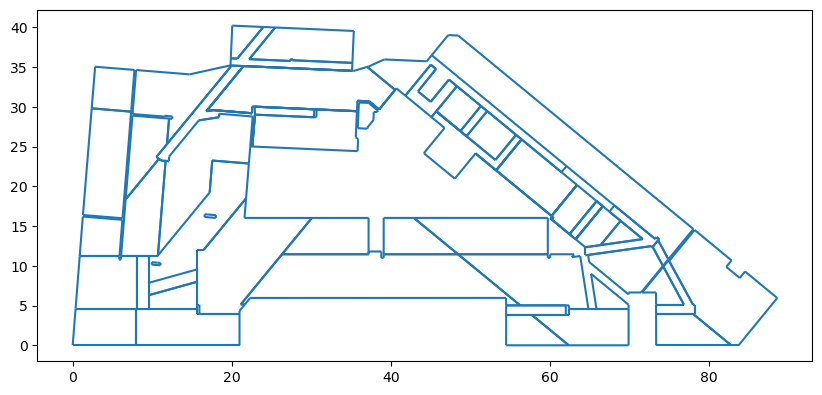

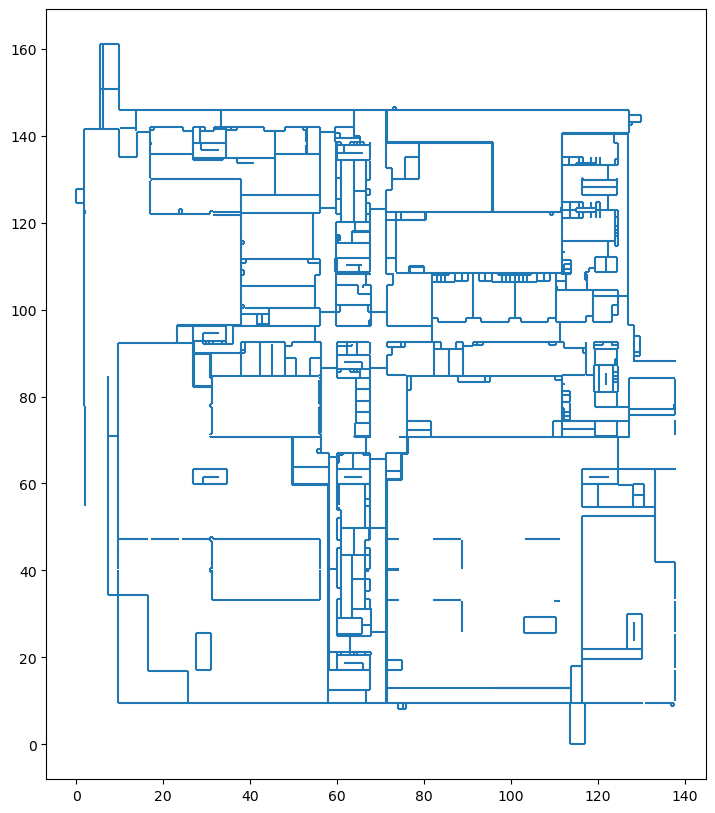

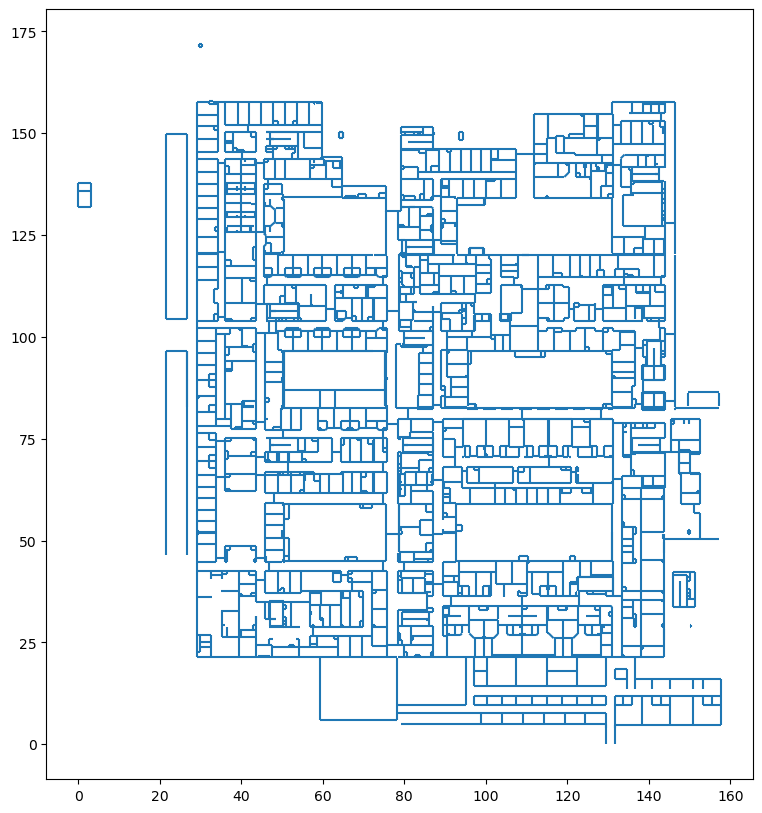

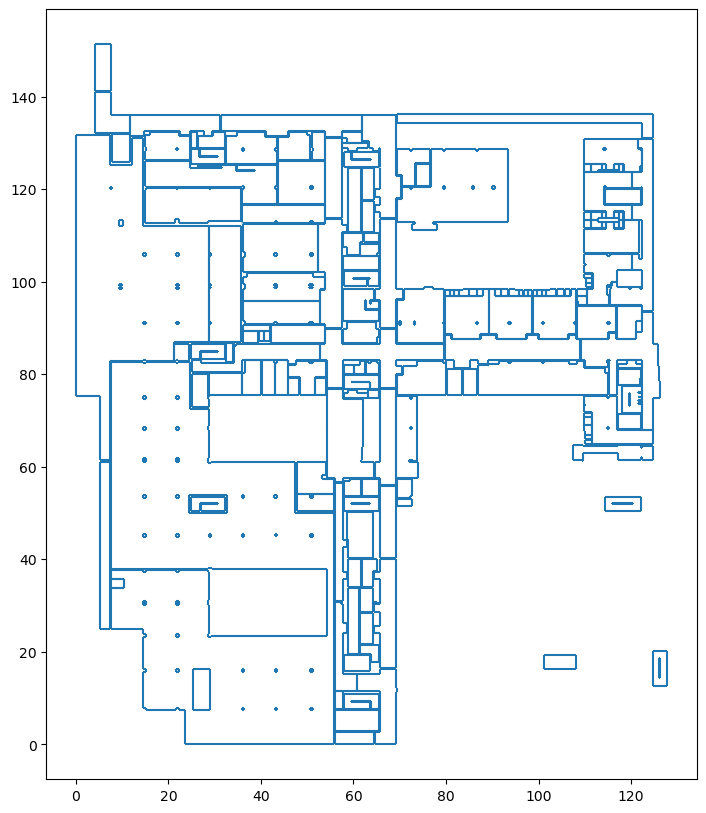

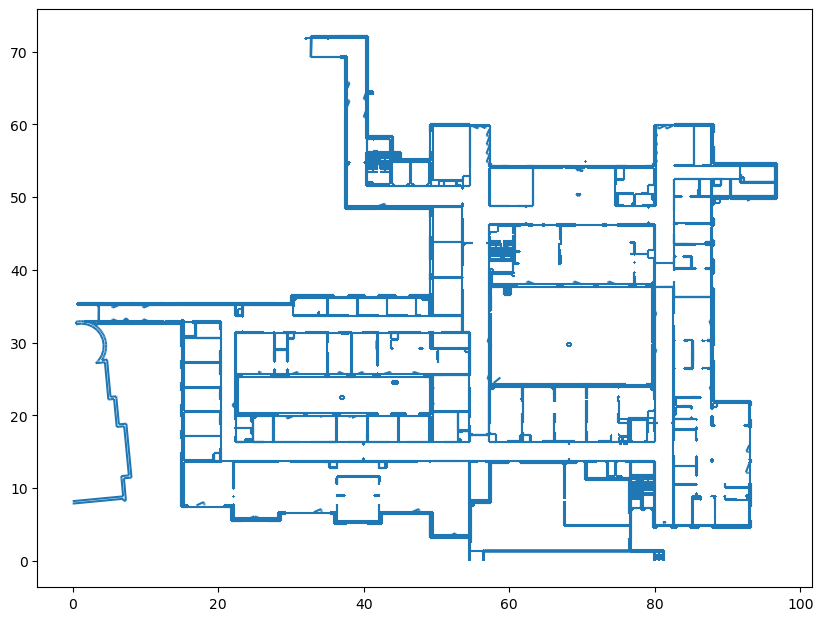

In [4]:
# Chargement des segments et affichage des plans
paths = []

# Limitation des affichages à 5 fichiers aléatoires
random.shuffle(files_names)
files_names = files_names[:5]

for file_name in files_names:
    paths.append(processed_dir / f"{file_name}_clean.geojson")

# Load the segments
segments = []
transform_parameters = []
for i, path in enumerate(paths):
    segment, transform_parameter = pg.load_segments(path)
    segments.append(segment)
    transform_parameters.append(transform_parameter)
    print(f"Map number {i} has been loaded")
    print(f"   Saved parameters for inverse transformation are: {transform_parameter}")
    print(f"   Has loaded {len(segment.geoms)} segments, total {segment.length:.0f}m, mean length {segment.length/len(segment.geoms):.4f}m")

#Plot the segments
for i, segment in enumerate(segments):
    pg.plot_GeometryCollection(segment, figsize=(10, 10))

---
## 🖼️ Étape 3 : Génération des images binaires

On génère une image binaire à partir des segments traités.
Résultat : une image binaire pgn dans `02_binary_images/`.

In [5]:
# Générations d'images png noir et blanc, traits épaissis, à partir des segments et sauvegarde des métadonnées de transformation

# Paramètres pour la génération des images
dpi_choice = 50  # Changer la résolution ici (ex: 30, 50, 100...)
thickness_choice = 9  # Épaisseur des lignes en pixels (impair de préférence)
scale = dpi_choice  # 1m = dpi_choice pixels

# Méthode de dilatation ('ellipse', 'cross', 'gaussian' 
# -> gaussien est plus efficace pour l'épaississement des traits obliques et courbes)
method_choice = 'gaussian'

# Génération des images avec le DPI et épaisseur des traits choisis
for i, segment, file_name in zip(range(len(segments)), segments, files_names):
    ccg.generate_binary_image(
        segment,
        transform_parameters[i],
        file_name,
        binary_images_dir,
        metadatas_dir,
        scale=scale,
        thickness=thickness_choice,
        method=method_choice
    )

Saved binary map: 02_binary_images/Output3_binary_image.png
Saved transform metadata: 03_metadatas/Output3_metadata.json

Saved binary map: 02_binary_images/NHT_Tours_plan_etage_T-T30S1_Walls_binary_image.png
Saved transform metadata: 03_metadatas/NHT_Tours_plan_etage_T-T30S1_Walls_metadata.json

Saved binary map: 02_binary_images/NHT_Tours_plan_etage_T-T3000_Walls_binary_image.png
Saved transform metadata: 03_metadatas/NHT_Tours_plan_etage_T-T3000_Walls_metadata.json

Saved binary map: 02_binary_images/NHT_Tours_plan_etage_T-T30S1_Spaces_binary_image.png
Saved transform metadata: 03_metadatas/NHT_Tours_plan_etage_T-T30S1_Spaces_metadata.json

Saved binary map: 02_binary_images/Output0_binary_image.png
Saved transform metadata: 03_metadatas/Output0_metadata.json



#### 🔎 Visualisation des images binaires générées

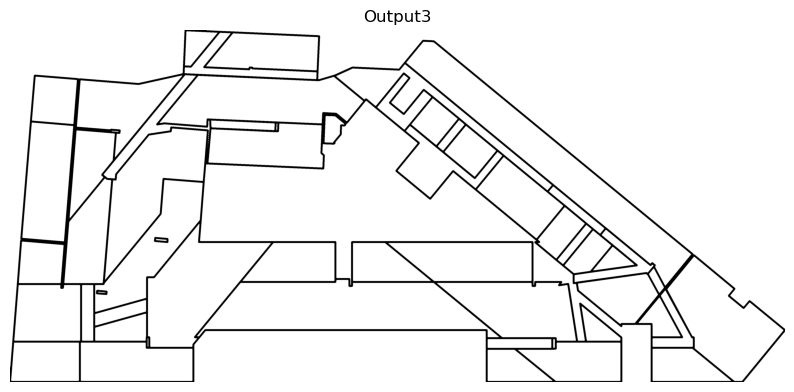

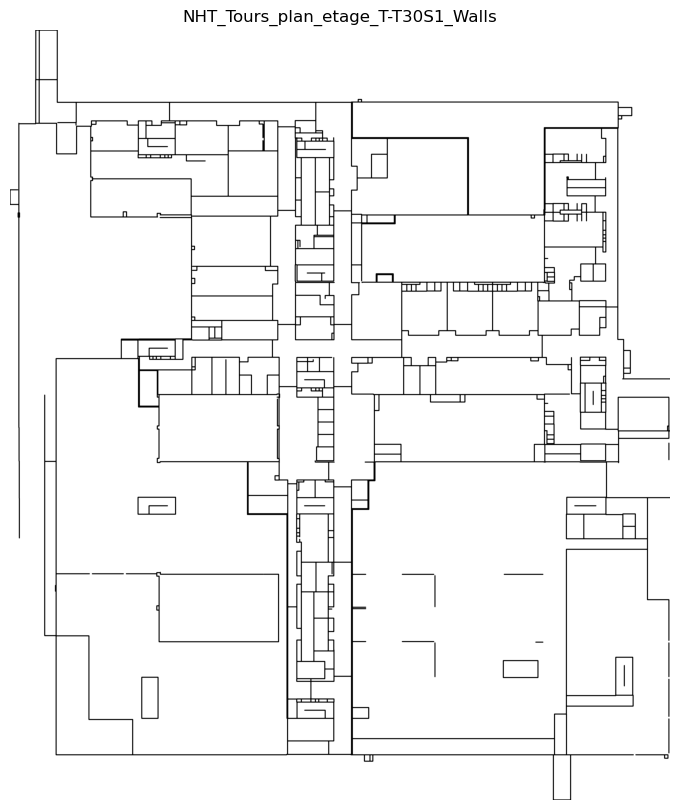

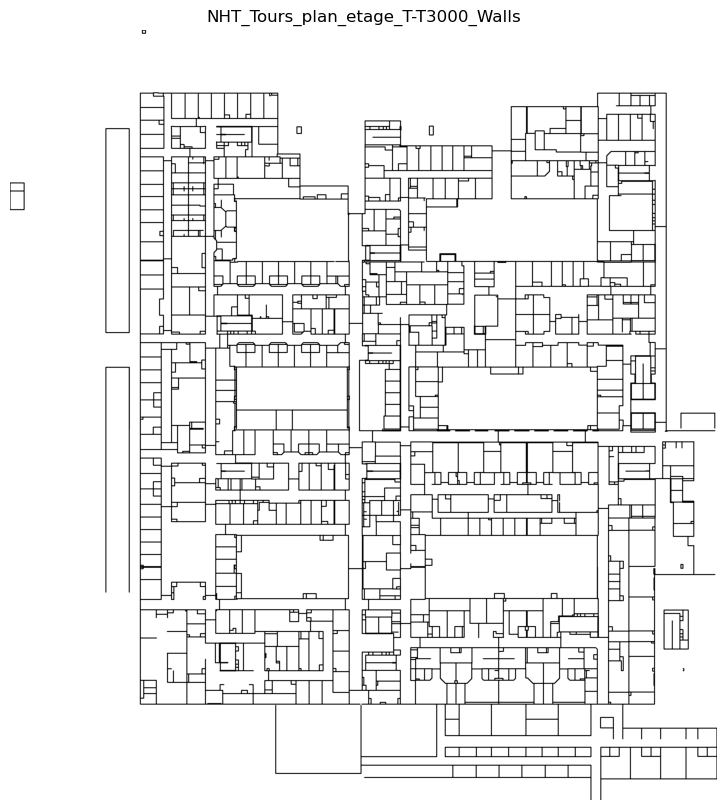

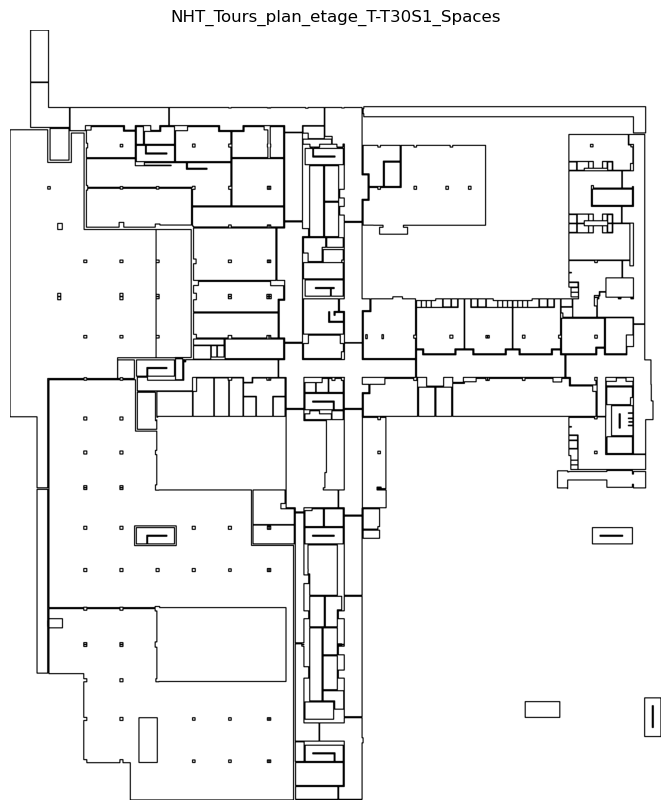

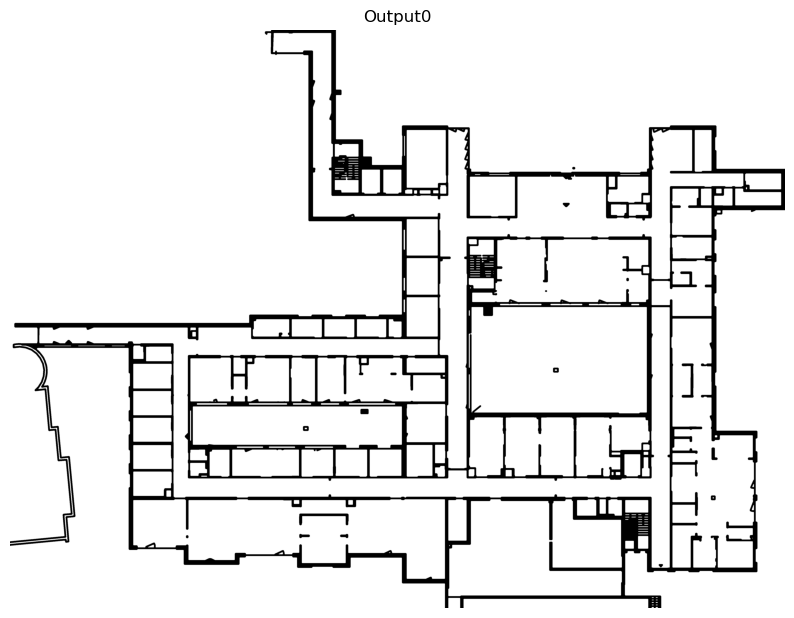

In [6]:
# Afficher les images binaires générées
for file_name in files_names:
    image_path = binary_images_dir / f"{file_name}_binary_image.png"
    binary_image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_image, cmap="gray")
    plt.axis("off")
    plt.title(f"{file_name}")
    plt.show()

---
## 🏠 Étape 4 : Détection des contours, filtrage des murs et export en GeoJSON

Dans cette étape, le script analyse les images binaires générées afin d'en extraire les **contours** correspondant aux pièces du bâtiment.  
Le processus applique plusieurs filtres :
1. **Filtrage par surface minimale** : pour ignorer les zones trop petites.
2. **Suppression des murs** : en se basant sur l'épaisseur et la simplification géométrique des contours.
3. **Conversion des contours en polygones géoréférencés** : chaque pièce est convertie en un polygone avec ses coordonnées d'origine.

🔎 **Résultat** :
- Une **image des pièces détectées**, stockée dans le dossier `04_contours_images/`   
- Un **fichier GeoJSON des contours**, stocké dans le dossier `05_rooms_contours_geojson/`  


In [7]:
# Génération des pièces (image + geojson) à partir des images binaires et des métadonnées de transformation

surface_minimale=1 # surface minimale en m²
surface_minimale_pixels = surface_minimale * (dpi_choice**2)  # Conversion en pixels
epaisseur_min_m=0.4

for file_name in files_names:
    ccg.generer_pieces_image_et_geojson(
            file_name,
            binary_images_dir,
            metadatas_dir,
            contours_images_dir,
            rooms_contours_geojson_dir,
            surface_minimale=surface_minimale_pixels,
            dpi=dpi_choice,
            epaisseur_min_m=epaisseur_min_m, 
    )

✅ 44 pièces détectées pour 'Output3'.
✅ Image sauvegardée : 04_contours_images/Output3_contours_image.png
GeoJSON avec échelle enregistré : 05_rooms_contours_geojson/Output3_rooms_contours.geojson

✅ 172 pièces détectées pour 'NHT_Tours_plan_etage_T-T30S1_Walls'.
✅ Image sauvegardée : 04_contours_images/NHT_Tours_plan_etage_T-T30S1_Walls_contours_image.png
GeoJSON avec échelle enregistré : 05_rooms_contours_geojson/NHT_Tours_plan_etage_T-T30S1_Walls_rooms_contours.geojson

✅ 638 pièces détectées pour 'NHT_Tours_plan_etage_T-T3000_Walls'.
✅ Image sauvegardée : 04_contours_images/NHT_Tours_plan_etage_T-T3000_Walls_contours_image.png
GeoJSON avec échelle enregistré : 05_rooms_contours_geojson/NHT_Tours_plan_etage_T-T3000_Walls_rooms_contours.geojson

✅ 142 pièces détectées pour 'NHT_Tours_plan_etage_T-T30S1_Spaces'.
✅ Image sauvegardée : 04_contours_images/NHT_Tours_plan_etage_T-T30S1_Spaces_contours_image.png
GeoJSON avec échelle enregistré : 05_rooms_contours_geojson/NHT_Tours_plan_etag

#### 🔎 Visualisation des différents contours de pèces détectées

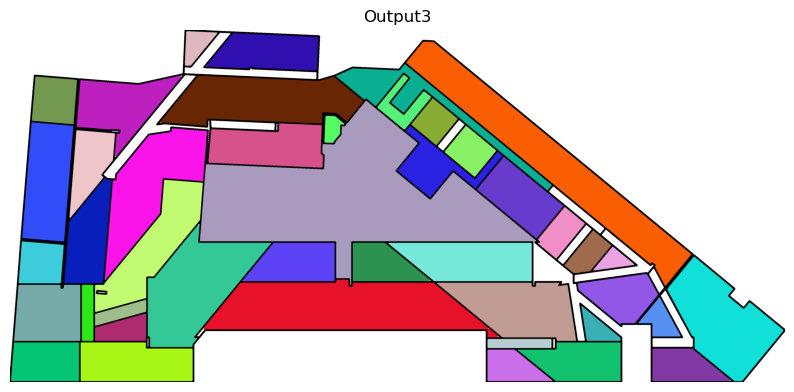

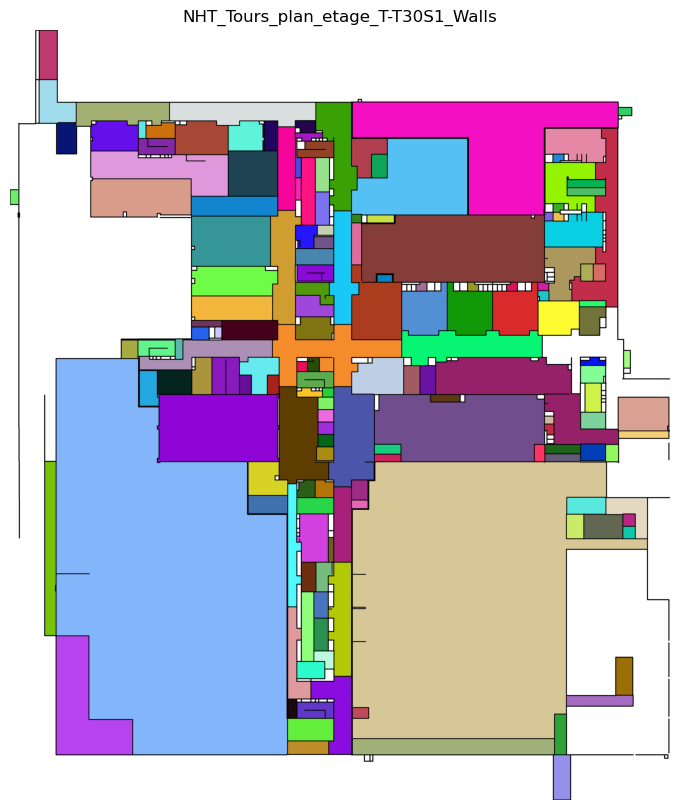

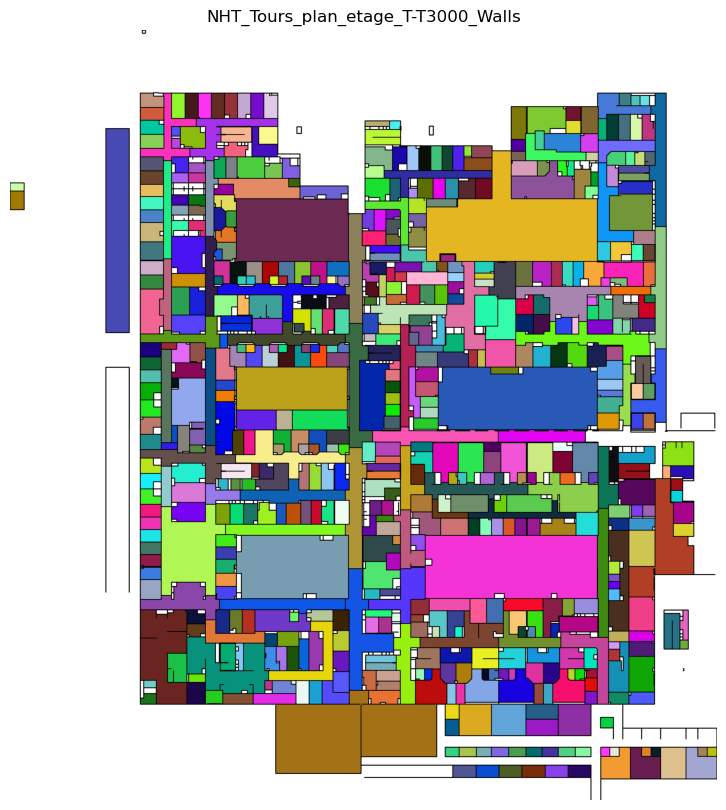

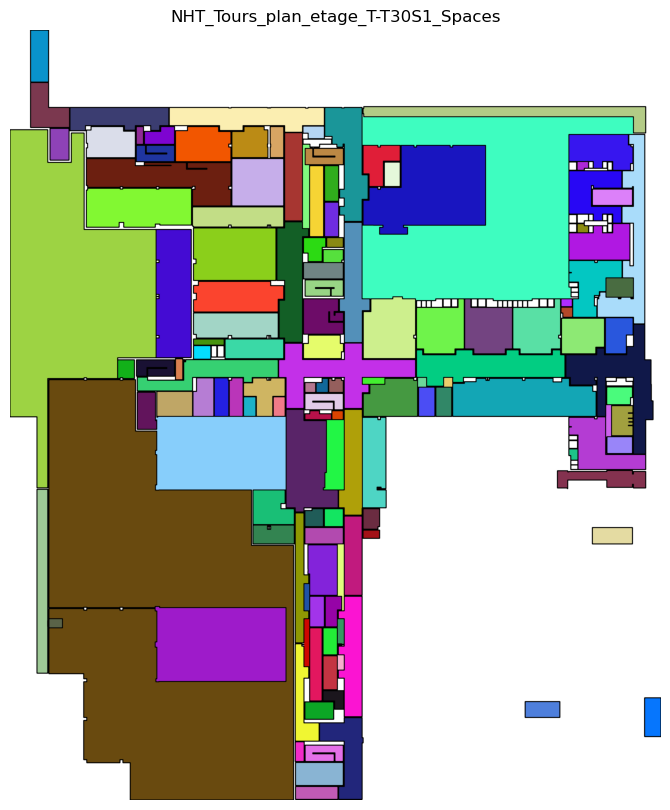

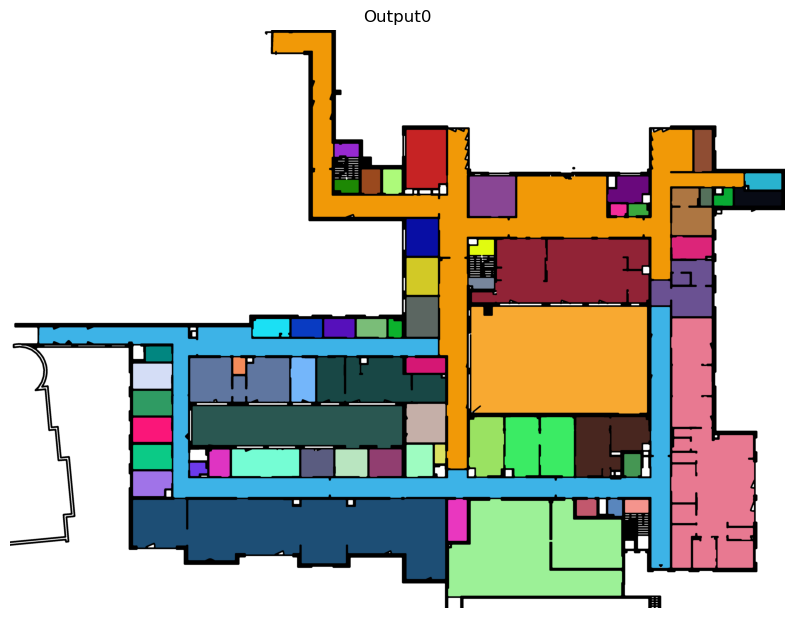

In [8]:
# Afficher les images binaires générées
for file_name in files_names:
    image_path = contours_images_dir / f"{file_name}_contours_image.png"
    binary_image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_image, cmap="gray")
    plt.axis("off")
    plt.title(f"{file_name}")
    plt.show()

#### 🔎 Visualisation des fichiers GeoJSON de sortie générés 

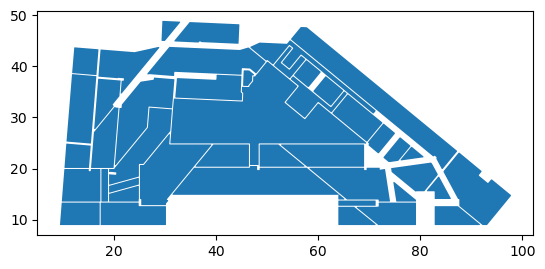

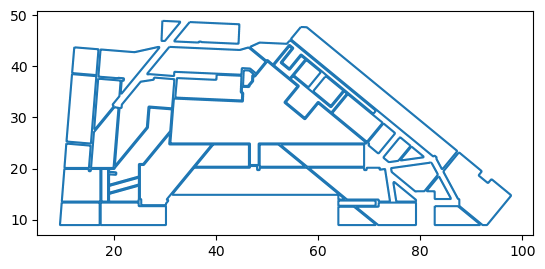

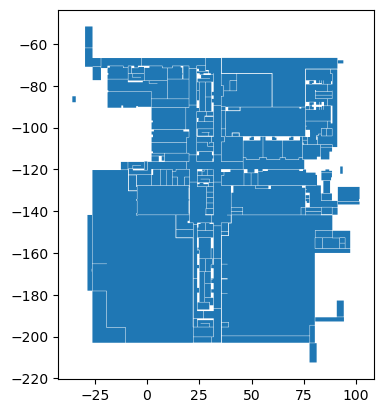

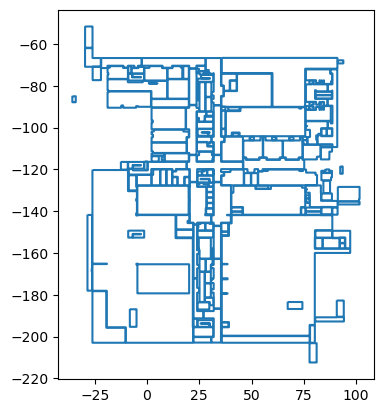

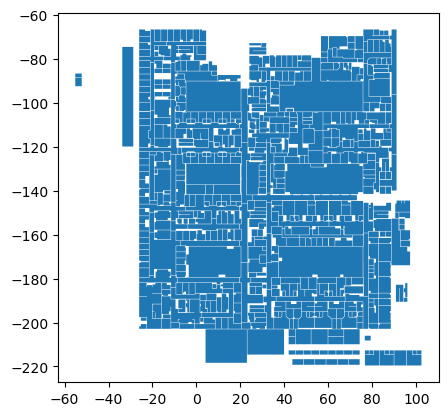

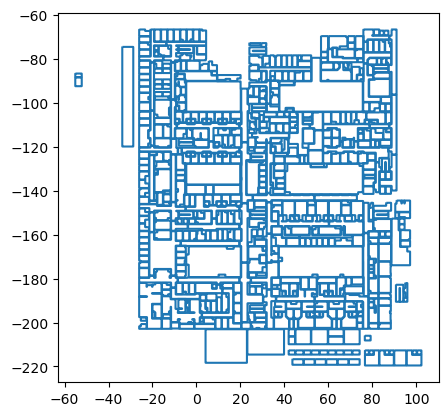

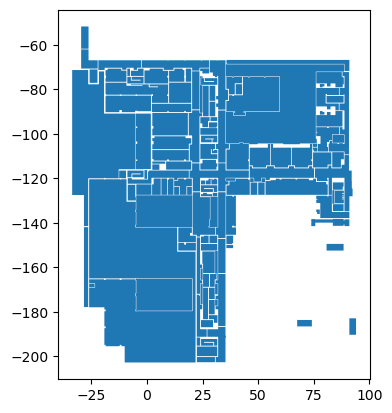

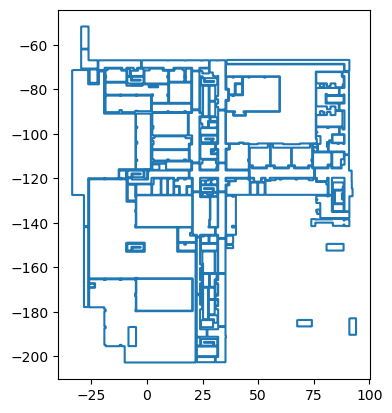

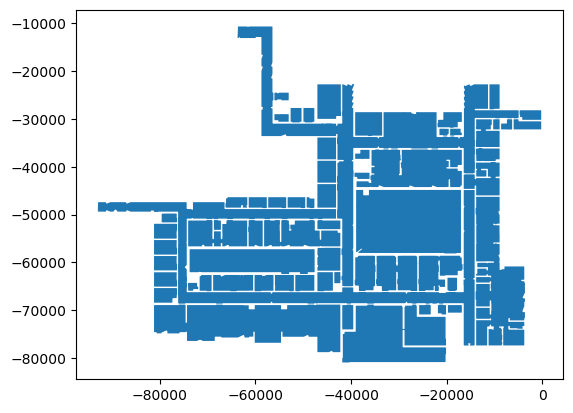

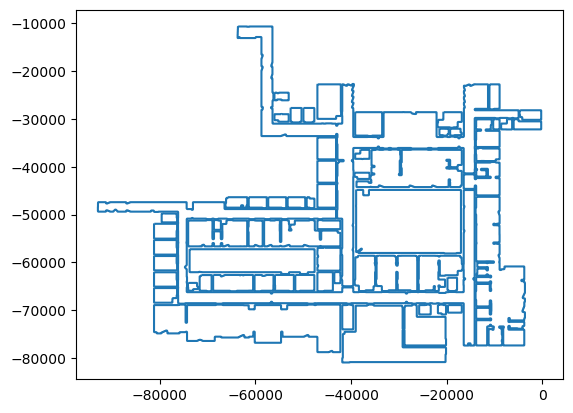

In [9]:
# Imprime les geojson : polygones & contours des pièces

for file_name in files_names:
    path = Path(rooms_contours_geojson_dir,f"{file_name}_rooms_contours.geojson")
    gdf = gpd.GeoDataFrame.from_file(path)
    gdf.plot(aspect=1)
    gdf.boundary.plot(aspect=1)

---
## ✅ Conclusion

Le **pipeline de traitement des plans GeoJSON** est désormais **opérationnel** ✅  
Il permet de traiter automatiquement des plans vectoriels, d'en extraire les **pièces** grâce à la détection de **contours filtrés**, et de générer des fichiers **prêts à l'emploi**.

### 🎯 Résultats produits :
- Une **image** avec les pièces détectées, enregistrée dans le dossier `04_contours_images/`  
- Un **fichier GeoJSON des contours des pièces**, enregistré dans le dossier `05_rooms_contours_geojson/`    



---
## 🛠️ Interface interactive de traitement

L'interface suivante permet de **sélectionner un fichier**, de **régler les paramètres** à la volée, et de **lancer l'analyse**.

In [10]:
vt.create_ui_pipeline()